In [1]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '1'
import tensorflow as tf
tf.compat.v1.disable_eager_execution()
config = tf.compat.v1.ConfigProto()
config.gpu_options.allow_growth = True
sess = tf.compat.v1.Session(config=config)
import cv2
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import sklearn
from keras import layers,losses #,Sequential,metrics
from keras.models import Model
import Utils
# from tensorflow.keras.layers import Layer
# from tensorflow.keras import optimizers
# from tensorflow.keras.optimizers.experimental import SGD
# from tensorflow.image import ssim

from Reconstruction import Reconstruction as M_PMRNN
from ViTReconstruction import Reconstruction as MViT_PMRNN
from DPMRNN import Reconstruction as DPMRNN 

In [2]:
#from tensorflow.python.compiler.tensorrt import trt_convert as trt
device = tf.config.list_physical_devices("GPU")
print(device)  # Check if GPU devices are visible
print(tf.test.is_built_with_cuda())  # Check if TensorFlow is built with CUDA support
#print(trt.trt_utils._pywrap_py_utils.get_linked_tensorrt_version())

tf.keras.backend.clear_session()

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
True


In [3]:
X_test=np.load('X_test.npy')
X_test.shape
first  = X_test[0]
Topredict = first[1:]
test = first[:-1]

# M-3D-PMRNN

In [4]:
M_3D_PMRNN = M_PMRNN()
M_3D_PMRNN.summary()
M_3D_PMRNN.compile()


Instructions for updating:
Colocations handled automatically by placer.
Model: "learned_prior"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
learned_prior_input (InputLa [(None, 256, 256, 1)]     0         
_________________________________________________________________
encoder_conv_1 (Conv2D)      (None, 256, 256, 16)      160       
_________________________________________________________________
batch_normalization_6 (Batch (None, 256, 256, 16)      64        
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 128, 128, 16)      0         
_________________________________________________________________
encoder_conv_2 (Conv2D)      (None, 128, 128, 32)      4640      
_________________________________________________________________
batch_normalization_7 (Batch (None, 128, 128, 32)      128       
_______________________________________________

In [5]:
M_3D_PMRNN = M_PMRNN.load(save_folder=f"M-3D-PMRNN-trained")

# ViT

In [6]:
ViT_PMRNN = MViT_PMRNN()
ViT_PMRNN.summary()
ViT_PMRNN.compile()


Model: "vision_transformer"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
patch_encoder (PatchEncoder) (None, 256, 256)          131328    
_________________________________________________________________
transformer_encoder (Transfo (None, 256, 256)          921600    
_________________________________________________________________
dense_8 (Dense)              (None, 128)               8388736   
_________________________________________________________________
dense_9 (Dense)              (None, 64)                8256      
Total params: 9,449,920
Trainable params: 9,449,920
Non-trainable params: 0
_________________________________________________________________
Model: "vision_transformer"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
patch_encoder (PatchEncoder) (None, 256, 256)          131328    
__________

In [7]:
ViT_PMRNN = MViT_PMRNN.load(save_folder=f"MViT-3D-PMRNN-final")

# 3D-PMRNN

In [4]:
D_PMRNN = DPMRNN()
D_PMRNN.summary()
D_PMRNN.compile()


Instructions for updating:
Colocations handled automatically by placer.
Model: "learned_prior"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
learned_prior_input (InputLa [(None, 256, 256, 1)]     0         
_________________________________________________________________
encoder_conv_1 (Conv2D)      (None, 256, 256, 16)      160       
_________________________________________________________________
batch_normalization_7 (Batch (None, 256, 256, 16)      64        
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 128, 128, 16)      0         
_________________________________________________________________
encoder_conv_2 (Conv2D)      (None, 128, 128, 32)      4640      
_________________________________________________________________
batch_normalization_8 (Batch (None, 128, 128, 32)      128       
_______________________________________________

In [5]:
D_PMRNN = DPMRNN.load(save_folder=f"3D-PMRNN")

In [6]:
from skimage.metrics import mean_squared_error

def porosity(im):
    threshold = 0.5  # Adjust the threshold as needed

    # Calculate the porosity using NumPy operations
    porosity = 1 - np.mean(im <= threshold)
    return porosity


def calculate_mae(list1, list2):
    if len(list1) != len(list2):
        raise ValueError("Both lists must have the same length.")
    
    n = len(list1)
    mae = sum(abs(y1 - y2) for y1, y2 in zip(list1, list2)) / n
    return mae

def calculate_mse(list1, list2):
    if len(list1) != len(list2):
        raise ValueError("Both lists must have the same length.")

    mse = np.mean([mean_squared_error(img1, img2) for img1, img2 in zip(list1, list2)])
    return mse

# Testing 

In [53]:
testing = []
inputLayer = first[0]
print(inputLayer.shape)
# for i in range(len(first)-1):
for i in range(len(test)):
    learned = M_3D_PMRNN.learnedPrior.predict(inputLayer.reshape(1,256,256,1))
    testing.append(M_3D_PMRNN.Generate.predict([inputLayer.reshape(1,256,256,1),learned.reshape(1,1,64)],steps=1))
    inputLayer = testing[-1]

(256, 256, 1)


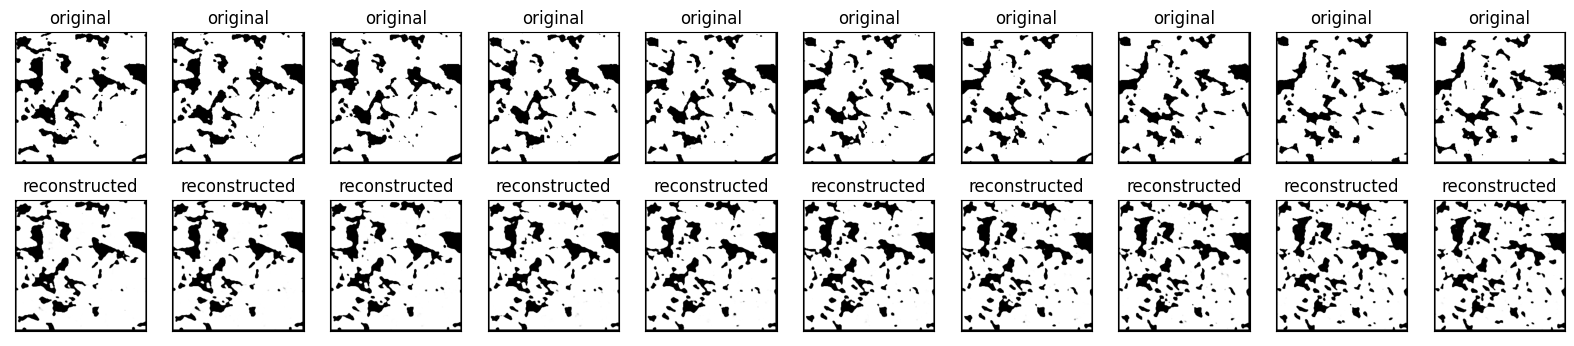

In [54]:
n = 10

plt.figure(figsize=(20,4))
for i in range(n):
    # original
    ax = plt.subplot(2,n,i+1)
    plt.imshow(Topredict[i].astype("float32"))
    plt.title('original')
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # reconstructed
    ax = plt.subplot(2,n,i+1+n)
    plt.imshow(testing[i].reshape(256,256,1))
    plt.title('reconstructed')
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

In [11]:
pore_testing = [porosity(im) for im in testing]
#print(pore_testing[:10])

pore_MPMRNN = [porosity(im) for im in Topredict]
#print(pore_MPMRNN[:10])

# print(Topredict.shape)
# print(np.array(testing).shape)
testing = np.array(testing).reshape(249,256,256,1)

mae_MPMRNN = calculate_mae(pore_testing,pore_MPMRNN)
mse_MPMRNN = calculate_mse(Topredict,testing)

print(mae_MPMRNN)
print(mse_MPMRNN)

0.2057535562170557
0.3795228239213108


In [56]:
testing = []
inputLayer = first[0]
print(inputLayer.shape)
# for i in range(len(first)-1):
for i in range(len(test)):
    learned = ViT_PMRNN.learnedPrior.predict(inputLayer.reshape(1,256,256,1))
    testing.append(ViT_PMRNN.Generate.predict([inputLayer.reshape(1,256,256,1),learned.reshape(1,1,256)],steps=1))
    inputLayer = testing[-1]

(256, 256, 1)


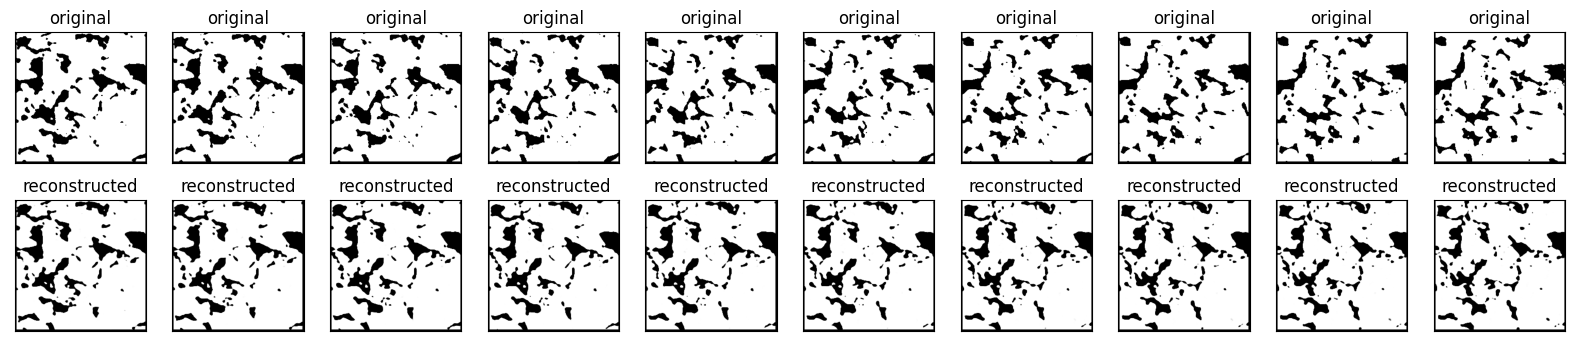

In [57]:
n = 10

plt.figure(figsize=(20,4))
for i in range(n):
    # original
    ax = plt.subplot(2,n,i+1)
    plt.imshow(Topredict[i].astype("float32"))
    plt.title('original')
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # reconstructed
    ax = plt.subplot(2,n,i+1+n)
    plt.imshow(testing[i].reshape(256,256,1))
    plt.title('reconstructed')
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

In [58]:


pore_ViT_PMRNN= [porosity(im) for im in Topredict]
#print(pore_MPMRNN[:10])

# print(Topredict.shape)
# print(np.array(testing).shape)
testing = np.array(testing).reshape(249,256,256,1)

mae_MPMRNN = calculate_mae(pore_testing,pore_ViT_PMRNN)
mse_MPMRNN = calculate_mse(Topredict,testing)

print(mae_MPMRNN)
print(mse_MPMRNN)

0.07449549173255522
0.26991701949399227


In [63]:
mae = calculate_mae(pore_ViT_PMRNN, pore_MPMRNN)
mae

0.0

In [9]:
testing = []
inputLayer = first[0]
print(inputLayer.shape)
# for i in range(len(first)-1):
for i in range(len(test)):
    learned = D_PMRNN.learnedPrior.predict(inputLayer.reshape(1,256,256,1))
    testing.append(D_PMRNN.Generate.predict([inputLayer.reshape(1,256,256,1),learned.reshape(1,1,64)],steps=1))
    inputLayer = testing[-1]

(256, 256, 1)


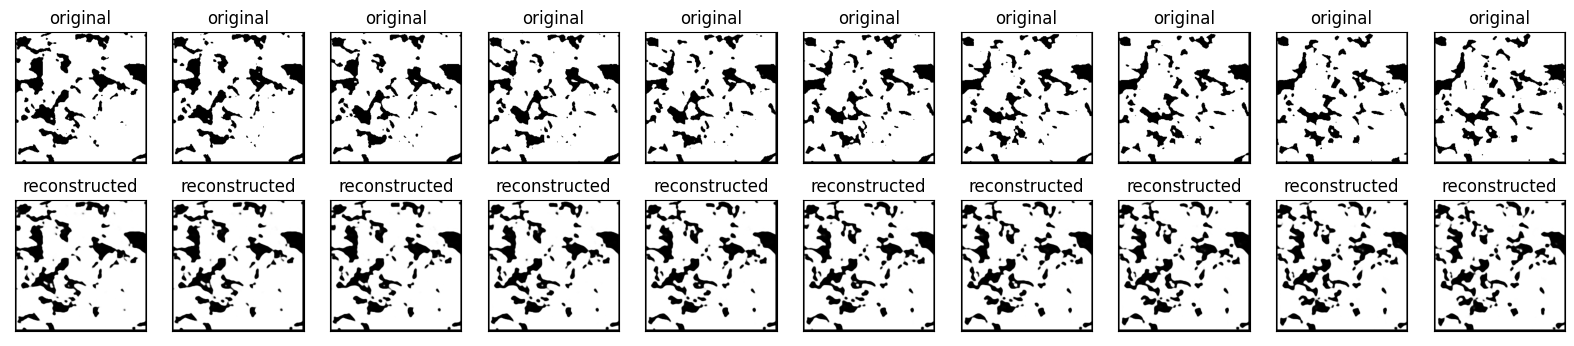

In [9]:
n = 10

plt.figure(figsize=(20,4))
for i in range(n):
    # original
    ax = plt.subplot(2,n,i+1)
    plt.imshow(Topredict[i].astype("float32"))
    plt.title('original')
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # reconstructed
    ax = plt.subplot(2,n,i+1+n)
    plt.imshow(testing[i].reshape(256,256,1))
    plt.title('reconstructed')
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

In [12]:

pore_ViT_D_PMRNN= [porosity(im) for im in Topredict]
#print(pore_MPMRNN[:10])

# print(Topredict.shape)
# print(np.array(testing).shape)
testing = np.array(testing).reshape(249,256,256,1)

mae_MPMRNN = calculate_mae(pore_testing,pore_ViT_D_PMRNN)
mse_MPMRNN = calculate_mse(Topredict,testing)

print(mae_MPMRNN)
print(mse_MPMRNN)

0.2057535562170557
0.3795228239213108


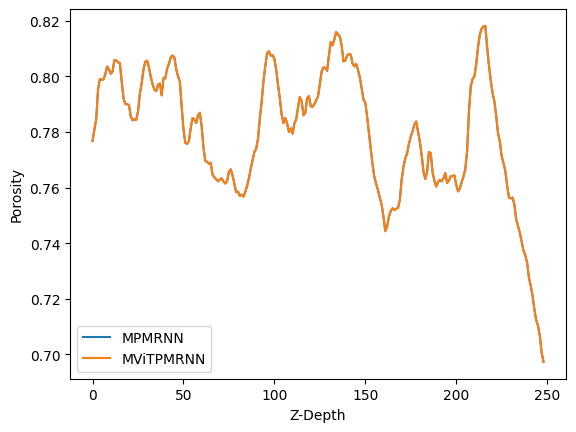

In [62]:
# Create the plot
# plt.plot(range(len(testing)), pore_testing, label='original')
plt.plot(range(len(testing)), pore_MPMRNN, label='MPMRNN')
plt.plot(range(len(testing)), pore_ViT_PMRNN, label='MViTPMRNN')

# Add labels and a legend
plt.xlabel('Z-Depth')
plt.ylabel('Porosity')
plt.legend()

# Display the plot
plt.show()

In [8]:
# import numpy as np
# from skimage import morphology, measure

In [9]:


# # Load the binary porous image
# image = voxels[0][4]  # Replace with your binary image data

# # Skeletonize the image
# skeleton = morphology.skeletonize(image)

# # Calculate the lineal-path function
# lineal_path = np.sum(skeleton)/np.sum(image)

# # Print the lineal-path value
# print(lineal_path)

In [10]:
# image = ...  # Replace with your binary image data

# # Calculate the two-point correlation function
# correlation = morphology.correlation_2d(image)

# # Print the correlation matrix
# print(correlation)

In [11]:
# # Load the binary porous image
# image = image_data[0]  # Replace with your binary image data

# # Label the connected components
# labels = measure.label(image, connectivity=1)

# # Calculate the two-point cluster function
# unique_labels, label_counts = np.unique(labels, return_counts=True)
# cluster_function = np.sum(label_counts[label_counts > 1]) / np.sum(label_counts)

# # Print the cluster function
# print(cluster_function)

In [17]:
# ps.metrics.two_point_correlation(im)

In [61]:

# paths = ps.filters.distance_transform_lin(im, mode='forward', axis=0)
# ps.imshow(paths);

In [62]:
# lpf = ps.metrics.lineal_path_distribution(paths, bins=range(1, 200, 10))

Text(0.5, 1.0, 'Probability Density Function')

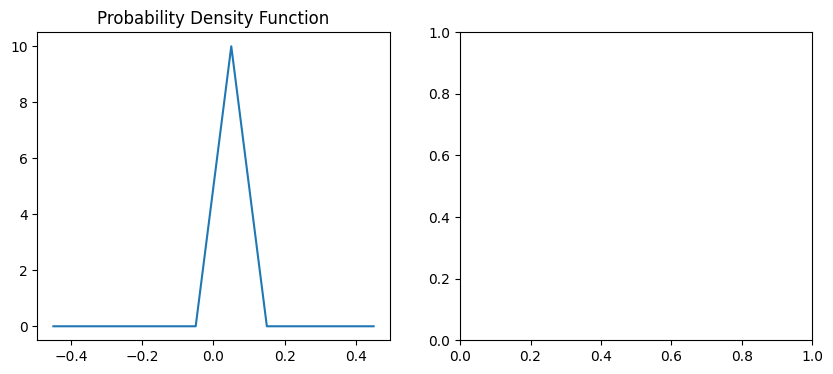

In [18]:
data = ps.metrics.lineal_path_distribution(voxels[0],log=True)
fig, ax = plt.subplots(1, 2, figsize=[10, 4])
ax[0].plot(data.LogL,data.pdf)
# ax[1].plot(data.L,data.cdf)
# ax[2].bar(data.L, data.cdf, data.bin_widths, edgecolor='k')
ax[0].set_title("Probability Density Function")
# ax[1].set_title("Cumulative Density Function")
# ax[2].set_title('Bar Plot');

In [64]:
e = ps.metrics.porosity(im)
print(e)

0.8048858642578125


In [68]:
im.shape

(256, 256, 1)

In [3]:
images = Utils.read_data("reconstructed.raw",array_shape=(250,256,256,1))
images.shape

(250, 256, 256, 1)

In [11]:
def porosity(im):
    threshold = 0.5  # Adjust the threshold as needed

    # Calculate the porosity using NumPy operations
    porosity = 1 - np.mean(im <= threshold)
    return porosity

In [13]:
por = [porosity(im) for im in voxels[0]]
por

[0.8048858642578125,
 0.8074951171875,
 0.8106689453125,
 0.815185546875,
 0.817138671875,
 0.818359375,
 0.8168792724609375,
 0.814056396484375,
 0.809417724609375,
 0.8060455322265625,
 0.80242919921875,
 0.800994873046875,
 0.8006591796875,
 0.8012542724609375,
 0.7994232177734375,
 0.7960357666015625,
 0.795654296875,
 0.7925262451171875,
 0.78570556640625,
 0.77874755859375,
 0.7689208984375,
 0.7608489990234375,
 0.7602996826171875,
 0.752838134765625,
 0.7479400634765625,
 0.7427520751953125,
 0.740936279296875,
 0.739837646484375,
 0.7382354736328125,
 0.7307281494140625,
 0.7224578857421875,
 0.7220916748046875,
 0.7237396240234375,
 0.7267303466796875,
 0.726593017578125,
 0.731048583984375,
 0.73870849609375,
 0.7457733154296875,
 0.751495361328125,
 0.75836181640625,
 0.7656402587890625,
 0.7691650390625,
 0.7733917236328125,
 0.7725067138671875,
 0.7744598388671875,
 0.776031494140625,
 0.775421142578125,
 0.7747955322265625,
 0.7736663818359375,
 0.771820068359375,
 0.770

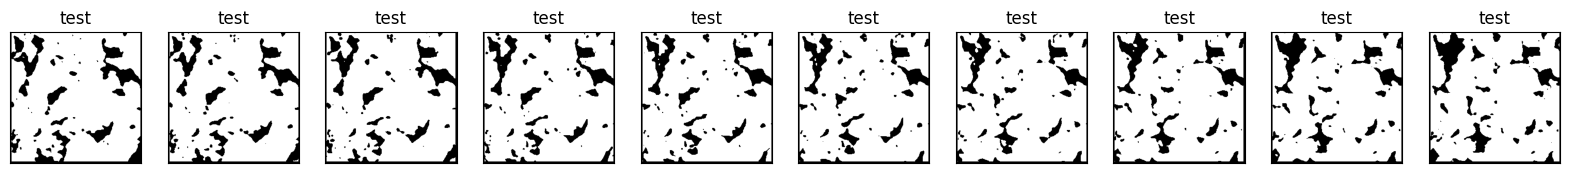

In [14]:
n = 10

plt.figure(figsize=(20,4))
for i in range(n):
    # original
    ax = plt.subplot(2,n,i+1)
    plt.imshow(voxels[0][i])
    plt.title('test')
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)


In [ ]:
import numpy as np

np.load("file.npy")